# 2D Brain Tumor Segmentation


## Table of contents
* Introduction
* Dataset
* Data-Preprocessing
* Data Loading
* Loss function
* Models
* Training
* Inference


## Introduction

The goal of this project is to create a computationally inexpensive pipeline for glioblastoma brain tumor segmentation.
In this Notebook, we will detail the different approaches taken to reduce the computational overhead often encountered when working with 3D medical data.


## Dataset
The training dataset is provided by the [BraTS20](https://www.med.upenn.edu/cbica/brats2020/data.html) challenge. It consists of 369 brain mpMRI scans with the corresponding segmentation masks of the tumorous region. The 3D volumes were skull-stripped and resampled to 1 mm isotropic resolution, with a dimension of (240, 240, 155) voxels. For each example, four modalities have been given: Fluid Attenuated Inversion Recovery (FLAIR), native (T1), post-contrast T1-weighted (T1Gd), and T2-weighted (T2). The segmentation labels are as follows: 0 Background, 1 Necrotic Tumor Core (NCR), 2 Edema (ED) and 4 Enhancing Tumor (ET).

We visualize the BraTS20_Training_001 sample, plotting the different modalities and the accompanying annotation. From left to right: FLAIR, T1, T1Gd, T2 and segmentation labels. 

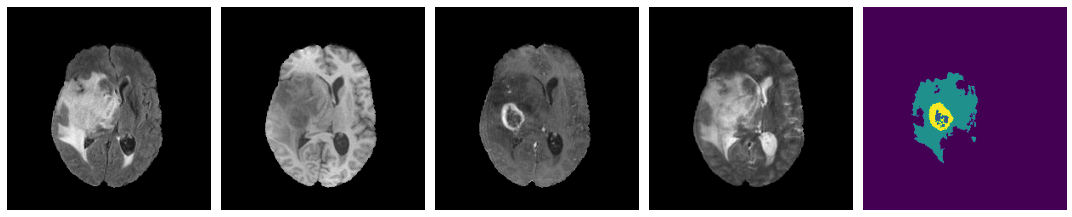

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk


path = "../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001"
imgs = [sitk.GetArrayFromImage(sitk.ReadImage(path + f"/BraTS20_Training_001_{m}.nii")).astype(np.float32)[75]
       for m in ["flair", "t1", "t1ce", "t2"]]
labels = sitk.GetArrayFromImage(sitk.ReadImage(path + "/BraTS20_Training_001_seg.nii")).astype(np.uint8)[75]
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
for i, img in enumerate(imgs):
    ax[i].imshow(img, cmap='gray')
    ax[i].axis('off')
ax[-1].imshow(labels, vmin=0, vmax=4)
ax[-1].axis('off')
plt.tight_layout()
plt.show()

## Data Pre-Processing

Data Pre-Processing plays an important role in our project since we do not have the adequate hardware to directly train our models with the provided 3D data. For each sample, we apply a biased cropping technique to extract a 3D patch with a random depth. To make our models more robust, the extracted patch will always have slices that contain both tumorous regions and healthy ones. This first pre-processing step, leaves each sample with a (Z, 240, 240) shape following the tensor format (Channels, Height, Width) and Z being a random number between 14 and 155. The second step is slightly reducing the Height and Width of each patch down to 224. Finally, for each modality of each sample we calculate the mean and the standard deviation within the non-zero brain, then we normalize the sample by subtracting the mean and dividing by the standard deviation. Only the brain region is normalized, the background intensities are kept at zero. We save the normalized arrays to a numpy format. The final shape of each sample modality is (Z, 224, 224).

In [2]:
import random
from skimage.exposure import rescale_intensity

def get_tumor(modality, segmentation):
    random.seed(100)
    mask = [any(element in [1, 2, 4] for element in i) 
            for i in segmentation.reshape((segmentation.shape[0], -1))]
    mask = [i for i in range(len(mask)) if mask[i] == True]
    z_min, z_max = min(mask), max(mask)
    
    epsilon = random.choice([-1, 0, 1]) * 14
    if z_min + epsilon < 0:
        epsilon = - z_min
    if z_max + epsilon > 153:
        epsilon = 153 - z_max

    return (modality[z_min + epsilon : z_max + epsilon + 1 :, :], 
            segmentation[z_min + epsilon : z_max + epsilon + 1, :, :])

def fix_labels(volume):
    volume[volume == 4.] = 3.
    return volume

def crop_volumes(v, m):
    return (v[:, 8: 232, 8: 232], m[:, 8: 232, 8:232])

def normalize_volume(volume):
    
    p10 = np.percentile(volume, 10)
    volume = rescale_intensity(volume, in_range=(p10, volume.max()))
    
    brain_mask = np.zeros(volume.shape, dtype=bool)
    brain_mask[volume > 0.] = True
    volume /= 255.
    mean = volume[brain_mask].mean()
    std = volume[brain_mask].std()
    volume = (volume - mean) / (std + 1e-8)
    volume[np.logical_or(brain_mask == False, volume < 0.)] = 0.
    
    return volume

def preprocess(volume, segmentation):
    volume_patch, seg_patch = get_tumor(volume, segmentation)
    volume_patch, seg_patch = crop_volumes(volume_patch, seg_patch)
    volume_patch, seg_patch = volume_patch.astype(np.float32), seg_patch.astype(np.uint8)
    volume_patch = normalize_volume(volume_patch)
    seg_patch = fix_labels(seg_patch)
    return volume_patch, seg_patch   

volume = sitk.GetArrayFromImage(sitk.ReadImage(path + "/BraTS20_Training_001_flair.nii"))
segmentation = sitk.GetArrayFromImage(sitk.ReadImage(path + "/BraTS20_Training_001_seg.nii"))
preprocessed_volume, preprocessed_seg = preprocess(volume, segmentation)

print(f"Preprocessed BraTS20_Training_001 sample T1 modality has shape {preprocessed_volume.shape}")
print(f"Preprocessed BraTS20_raining_001 sample annotations has shape {preprocessed_seg.shape}")

Preprocessed BraTS20_Training_001 sample T1 modality has shape (83, 224, 224)
Preprocessed BraTS20_raining_001 sample annotations has shape (83, 224, 224)


## Data Loading

After Pre-Processing all the modalities for each training sample, we create a simple data loading pipeline. Instead of feeding our models the 3D patches we created, we decided to further reduce the computational load by randomly sampling 2D slices and using them as input. We make use of the Object-Oriented Pytorch Framework to create the class necessary for generating the inputs. With each call, we select a random sample from which we select a random slice. We stack the four modalities of the corresponding slice to get a tensor of shape (4, 224, 224). The BraTS evaluates submitted models based on their segmentation results of 3 distinct slightly overlapping labels: Whole Tumor (NCR + ED + ET), Tumor Core (NCR + ET) and Edema (ED). To create these labels, we first create a one-hot representation of the given annotations then simply sum the necessary classes. The final shape of our target segmentation mask is (3, 224, 224). We finally assemble our inputs in batches of 16, as well as our annotations. The input and target shapes of our models are (16, 4, 224, 224) and (16, 3, 224, 224), respectively.

In [3]:
import os
import pandas as pd
from itertools import chain
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


images_dir = ["../input/brats2020-tf-flair/BraTS2020_TrainingData_tumour_focused_flair",
               "../input/brats2020-tf-t1/BraTS2020_TrainingData_tumour_focused_t1",
               "../input/brats2020-tf-t2/BraTS2020_TrainingData_tumour_focused_t2",
               "../input/brats2020-tf-t1ce/BraTS2020_TrainingData_tumour_focused_t1ce",
               "../input/brats-tf-seg/BraTS2020_TrainingData_tumour_focused_seg"] # Files Directories.

batch_size = 16 # Batch size.
workers = 2 # Number of data loaders' workers.

class BrainTumorSegmentationDataset(Dataset):
    """ Brain MRI Dataset for Glioma Tumor """
    
    """ Creates a Dataset to sample FLAIR slices and corresponding seg masks.
        
        input:
        - images_dir (string) = Directory of subjects' files.
        - subset (string) = type of subset used : All the data or train / validation.
        - transforms (function) = Set of Data Augmentation to apply to samples.
        - random_sampling (bool) = randomize sample generation process.
        - seed (int) = the randomization process seed.
    """
    
    def __init__(self, images_dir, subset="train", transforms=None, random_sampling=True, seed=1995):
        
        assert subset in ["all", "train", "validation"]
        
        self.transforms = transforms
        self.random_sampling = random_sampling
        self.flair_paths = {}
        self.t1_paths = {}
        self.t2_paths= {}
        self.t1ce_paths = {}
        self.seg_paths = {}
        self.slice_weights = {}
        self.patients = []
        
        print("Creating {} dataset...".format(subset))
        
        for (dirpath, dirnames, filenames) in sorted(chain.from_iterable(os.walk(path) for path in images_dir)):    
            for filename in sorted(filter(lambda f: "npy" in f, filenames)):
                filepath = os.path.join(dirpath, filename)
                patient_id = dirpath.split("/")[-1].split("_")[-1]
                if "t1ce" in filename:
                    self.t1ce_paths[patient_id] = filepath
                elif "t1" in filename:
                    self.t1_paths[patient_id] = filepath
                elif "flair" in filename:
                    self.flair_paths[patient_id] = filepath
                elif "t2" in filename:
                    self.t2_paths[patient_id] = filepath
                elif "seg" in filename:
                    self.seg_paths[patient_id] = filepath
                else:
                    self.slice_weights[patient_id] = np.load(filepath)

        self.patients = sorted(self.slice_weights)
        num_slices = pd.read_csv("../input/brats2020-tf-flair/num_slices.csv", 
                                 converters={'0': lambda x: str(x)})
        num_slices = dict(list(num_slices.to_records(index=False)))
        
        # reduce the total samples number
        random.seed(seed) #setting the random seed
        self.patients = random.sample(self.patients, k=150)
        
        # selecting subset
        if subset is not "all":
            validation_patients = random.sample(self.patients, k=20) #k equals to 0.2 * len(volumes) 
            if subset == "validation":
                self.patients = validation_patients
            else:
                self.patients = list(set(self.patients).difference(validation_patients))
        
        self.flair_paths = [self.flair_paths[p] for p in self.patients]
        self.t1_paths = [self.t1_paths[p] for p in self.patients]
        self.t1ce_paths = [self.t1ce_paths[p] for p in self.patients]
        self.t2_paths = [self.t2_paths[p] for p in self.patients]
        self.seg_paths = [self.seg_paths[p] for p in self.patients]
        self.num_slices = [num_slices[p] for p in self.patients]
        self.slice_weights = [self.slice_weights[p] for p in self.patients]
        
        # Calculating probabilities for sampling slices based on seg masks frequency
        self.slice_weights = [(s + (s.sum() * 0.1 / len(s))) / (s.sum() * 1.1) for s in self.slice_weights]
        
        # Creating global index for patient and slice (idx -> (p_idx, s_idx))
                                     
        self.patient_slice_index = list(zip(sum([[i] * self.num_slices[i] for i in range(len(self.num_slices))], []),
                                           sum([list(range(i)) for i in self.num_slices], [])))
        
        print("Done creating {} dataset... \n".format(subset))
        
    def __len__(self):
        # required to override to create custom torch dataset.
        
        return len(self.patient_slice_index)
    
    def __getitem__(self, idx):
        # required to override to create custom torch dataset.
        
        patient_idx = self.patient_slice_index[idx][0]
        slice_idx = self.patient_slice_index[idx][1]
        
        if self.random_sampling:
            patient_idx = np.random.randint(len(self.patients))
            slice_idx = np.random.choice(range(self.num_slices[patient_idx]),
                                        p=self.slice_weights[patient_idx])
           
        flair = np.load(self.flair_paths[patient_idx], mmap_mode="r")
        t1 = np.load(self.t1_paths[patient_idx], mmap_mode="r")
        t1ce = np.load(self.t1ce_paths[patient_idx], mmap_mode="r")
        t2 = np.load(self.t2_paths[patient_idx], mmap_mode="r")
        seg = np.load(self.seg_paths[patient_idx], mmap_mode="r")
        
        
        image = np.array([flair[slice_idx], t1[slice_idx], 
                             t1ce[slice_idx], t2[slice_idx]])
        mask = np.array(seg[slice_idx])
        
        
        # apply Data Augmentation if any.
        if self.transforms is not None:
            image, mask = self.transforms((image, mask))
        
        def one_hot(a, num_classes):
              return np.squeeze(np.eye(num_classes)[a])
        
        one_hot_mask = one_hot(mask.astype(int), num_classes=4)
        
        masks = np.zeros((3, 224, 224))
        masks[0] = np.sum(one_hot_mask[..., 1:], axis=-1) # WT
        masks[1] = np.sum(one_hot_mask[..., 1::2], axis=-1) # TC
        masks[2] = one_hot_mask[..., 3] # ET
        
        # convert to torch tensor.
        image_tensor = torch.from_numpy(image.astype(np.float32))
        mask_tensor = torch.from_numpy(masks.astype(np.float32))
        
        return image_tensor, mask_tensor
    
def datasets(images_dir):
    # Creating Train and Validation datasets.
    
    train = BrainTumorSegmentationDataset(images_dir, subset="train")
    validation = BrainTumorSegmentationDataset(images_dir, subset="validation", random_sampling=False)
    return train, validation

def data_loaders(batch_size, workers):
    # Creating PyTorch's Train and Validation data loaders
    
    train, validation = datasets(images_dir)
    
    loader_train = DataLoader(train, batch_size=batch_size, shuffle=True, 
                              drop_last=True, num_workers=workers)
    loader_validation = DataLoader(validation, batch_size=batch_size, 
                                   drop_last=False, num_workers=workers)
    
    return loader_train, loader_validation

train_set, val_set = datasets(images_dir)
loader_train, loader_val = data_loaders(batch_size, workers)

print(f"Total Number of Training samples : {len(train_set)} image")
print(f"Total Number of Validation samples : {len(val_set)} image")
print(f"Training Batch Tensor shape : {next(iter(loader_train))[0].size()}")

Creating train dataset...
Done creating train dataset... 

Creating validation dataset...
Done creating validation dataset... 

Creating train dataset...
Done creating train dataset... 

Creating validation dataset...
Done creating validation dataset... 

Total Number of Training samples : 8820 image
Total Number of Validation samples : 1410 image
Training Batch Tensor shape : torch.Size([16, 4, 224, 224])


## Loss Function

We use the Dice Loss as our cost function since it has proven to work best in segmentation tasks.
Instead of considering each label as its own seperate class and calculating the mean loss over the total number of classes, we calculate the loss over the output tensor without such differentiation. We noticed that this approach yields better results and is more robust to class imbalance:

### $$ \mathcal{L}_{Dice} = 1 - \dfrac{2 \sum_{i} y_{i}g_{i}}{\sum_{j} y_{j} + \sum_{j} g_{j}} $$

Where $y$ is the model prediction and $g$ is the ground truth.

In [4]:
class MultiClassDiceLoss(nn.Module):
    
    def __init__(self):
        super(MultiClassDiceLoss, self).__init__()
        self.smooth = 1e-7
        
    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred.contiguous().view(-1)
        y_true = y_true.contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        union = y_pred.sum() + y_true.sum() + self.smooth
        dsc = (2. * intersection) / union
        return 1. - dsc

## Models: U-Net

In this project, we tested out the [U-Net](https://arxiv.org/abs/1505.04597) (see below figure) as well as several well-performing U-Net variants, such as, the [U-Net++](https://arxiv.org/abs/1807.10165), [Attention U-Net](https://arxiv.org/abs/1804.03999) and the [Spatial-Channel Attention U-Net](https://www.frontiersin.org/articles/10.3389/fbioe.2020.00670/full).\
The U-Net has been a staple in Medical Imaging Segmentation. With its Encoder-Decoder architecture, it's able to perform feature-extraction via the repeating convolutional blocks then with its rich Decoder coupled with the skip-connection, we can propagate contextual information and capture high-resolution features from the Encoder.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [5]:
!pip install torch-summary

In [6]:
from collections import OrderedDict
from torchsummary import summary

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, base_features=64):
        super(UNet, self).__init__()
        
        self.encoder1 = UNet._block(in_channels, base_features, name="enc1_")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(base_features, base_features * 2, name="enc2_")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(base_features * 2, base_features * 4, name="enc3_")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(base_features * 4, base_features * 8, name="enc4_")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bottleneck = UNet._block(base_features * 8, base_features * 16, name="bottleneck_")
        
        self.upconv4 = nn.ConvTranspose2d(base_features * 16, base_features * 8, kernel_size=2, stride=2)
        self.decoder4 = UNet._block((base_features * 8) * 2, base_features * 8, name="dec4_")
        self.upconv3 = nn.ConvTranspose2d(base_features * 8, base_features * 4, kernel_size=2, stride=2)
        self.decoder3 = UNet._block((base_features * 4) * 2, base_features * 4, name="dec3_")
        self.upconv2 = nn.ConvTranspose2d(base_features * 4, base_features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNet._block((base_features * 2) * 2, base_features * 2, name="dec2_")
        self.upconv1 = nn.ConvTranspose2d(base_features * 2, base_features, kernel_size=2, stride=2)
        self.decoder1 = UNet._block(base_features * 2, base_features, name="dec1_")
        
        self.final = nn.Conv2d(in_channels=base_features, out_channels=out_channels, kernel_size=1)
        
    
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        
        bottleneck = self.bottleneck(self.pool4(enc4))
        
        dec4 = self.decoder4(torch.cat((self.upconv4(bottleneck), enc4), dim=1))
        dec3 = self.decoder3(torch.cat((self.upconv3(dec4), enc3), dim=1))
        dec2 = self.decoder2(torch.cat((self.upconv2(dec3), enc2), dim=1))
        dec1 = self.decoder1(torch.cat((self.upconv1(dec2), enc1), dim=1))
        
        return torch.sigmoid(self.final(dec1))
    
    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(OrderedDict([
            (name + "conv1", nn.Conv2d(in_channels=in_channels, out_channels=features, 
                                       kernel_size=3, padding=1, bias=False)), 
            (name + "bnorm1", nn.BatchNorm2d(num_features=features)), 
            (name + "relu1", nn.ReLU(inplace=True)),
            (name + "conv2", nn.Conv2d(in_channels=features, out_channels=features, 
                                      kernel_size=3, padding=1, bias=False)),
            (name + "bnorm2", nn.BatchNorm2d(num_features=features)),
            (name + "relu2", nn.ReLU(inplace=True))
        ]))

summary(UNet(4, 3), input_size=(4, 224, 224), verbose=False)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       2,304
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       36,864
|    └─BatchNorm2d: 2-5                  128
|    └─ReLU: 2-6                         --
├─MaxPool2d: 1-2                         --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-7                       73,728
|    └─BatchNorm2d: 2-8                  256
|    └─ReLU: 2-9                         --
|    └─Conv2d: 2-10                      147,456
|    └─BatchNorm2d: 2-11                 256
|    └─ReLU: 2-12                        --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Conv2d: 2-13                      294,912
|    └─BatchNorm2d: 2-14                 512
|    └─ReLU: 2-15                        --
|    └─Conv2d: 2-16                      589,

## Training

We train our models for $20$ epochs with a learning rate of $10^{-4}$ using Adam optmizer as it yielded the best results during our testings.

In [7]:
from utils import * # Utility functions for calculating and displaying metrics, check utils.py.
import torch.optim as optim

epochs = 20 # Number of Epochs.
lr = 1e-4 # Neural Network Learning Rate.
weights = "./" # Weights root directory.
in_channels = 4 # Number of input channels.
out_channels = 3 # Number of output channels.

def train_validate_multi():
    # Neural Network Training loop
    
    device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")
    print("Device used: {}".format(device))
    loader_train, loader_validation = data_loaders(batch_size, workers)
    loaders = {"train": loader_train, "validation": loader_validation}
    model = UNet(in_channels, out_channels, base_features=64)
    model.to(device)
    model.apply(weights_init)
    criterion = MultiClassDiceLoss()
    best_validation_dsc = 0.
    best_WT, best_TC, best_ET = 0., 0., 0.
    best_NET, best_ED = 0., 0.
    optimizer = optim.Adam(model.parameters(), lr=lr)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.75)
    
    loss_train = []
    loss_validation = []
    
    step = 0
    
    for epoch in range(epochs):
        for phase in ["train", "validation"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            validation_pred = []
            validation_true = []
            
            for i, sample in enumerate(loaders[phase]):
                if phase == "train":
                    step += 1
                x, y_true = sample
                x, y_true = x.to(device), y_true.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    y_pred = model(x)
                    loss = criterion(y_pred, y_true)
                    
                    if phase == "validation":
                        loss_validation.append(loss.item())
                        y_pred_np = y_pred.detach().cpu().numpy()
                        validation_pred.extend(y_pred_np[s] for s in range(y_pred_np.shape[0]))
                        y_true_np = y_true.detach().cpu().numpy()
                        validation_true.extend(y_true_np[s] for s in range(y_true_np.shape[0]))
                    if phase == "train":
                        loss_train.append(loss.item())
                        loss.backward()
                        optimizer.step()
            
            if phase == "train":
                log_loss_summary(loss_train, epoch, prefix="train_")
                loss_train = []
            
            if phase == "validation":
                log_loss_summary(loss_validation, epoch, prefix="validation_")
                mean_dsc = np.mean(dsc_per_volume(validation_pred, validation_true, 
                                                 loader_validation.dataset.patient_slice_index))
                WT_list, TC_list, ET_list, NEC_list, ED_list = dsc_per_volume(validation_pred, validation_true, 
                                                                              loader_validation.dataset.patient_slice_index, True)
                mean_WT, mean_TC, mean_ET = np.mean(WT_list), np.mean(TC_list), np.mean(ET_list)
                mean_NEC, mean_ED = np.mean(NEC_list), np.mean(ED_list)
                log_scalar_summary("val_dsc", mean_dsc, epoch)
                log_class_summary(mean_WT, mean_TC, mean_ET, epoch)
                log_class_orig_summary(mean_NEC, mean_ED, epoch)
                if mean_dsc > best_validation_dsc:
                    best_validation_dsc = mean_dsc
                    best_WT, best_TC, best_ET = mean_WT, mean_TC, mean_ET
                    best_NEC, best_ED = mean_NEC, mean_ED
                    torch.save(model.state_dict(), os.path.join(weights, "unet.pt"))
                loss_validation = []
                
        #scheduler.step()
                        
    print("\nBest validation mean DSC: {:4f}".format(best_validation_dsc))
    print("Best validation mean WT DSC: {:4f}".format(best_WT))
    print("Best validation mean TC DSC: {:4f}".format(best_TC))
    print("Best validation mean ET DSC: {:4f}".format(best_ET))
    print("Best validation mean NEC DSC: {:4f}".format(best_NEC))
    print("Best validation mean ED DSC: {:4f}".format(best_ED))
    

train_validate_multi()

Device used: cuda:0
Creating train dataset...
Done creating train dataset... 

Creating validation dataset...
Done creating validation dataset... 

epoch 1 | train_loss: 0.8702289411247102
epoch 1 | validation_loss: 0.8588872478249368
epoch 1 | val_dsc: 0.7615292083097513
epoch 1 | mean_WT: 0.838608, mean_TC: 0.632223, mean_ET: 0.723624
epoch 1 | mean_NEC: 0.289127, mean_ED: 0.189327
epoch 2 | train_loss: 0.5261241434490183
epoch 2 | validation_loss: 0.4984695978378982
epoch 2 | val_dsc: 0.8658464305952911
epoch 2 | mean_WT: 0.901947, mean_TC: 0.819011, mean_ET: 0.792224
epoch 2 | mean_NEC: 0.507390, mean_ED: 0.734284
epoch 3 | train_loss: 0.1757311623022907
epoch 3 | validation_loss: 0.32527425717771724
epoch 3 | val_dsc: 0.8733415780696477
epoch 3 | mean_WT: 0.902909, mean_TC: 0.840604, mean_ET: 0.785928
epoch 3 | mean_NEC: 0.613940, mean_ED: 0.755092
epoch 4 | train_loss: 0.09837955690771612
epoch 4 | validation_loss: 0.24747938386509927
epoch 4 | val_dsc: 0.8916328259640842
epoch 4

## Inference 

We save our best U-Net model and calculate the following metrics:
* Mean *Precision*
* Mean *Sensitivity*
* Mean *Specificity*
* Mean *F1-score*
* Mean *IoU*

In [8]:
from skimage.io import imread, imsave

device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")
print("Device used: {}".format(device))
_, loader_validation = data_loaders(batch_size, workers)
model = UNet(in_channels, out_channels, base_features=64)
model.to(device)

state_dict = torch.load(os.path.join(weights, "unet.pt"))
model.load_state_dict(state_dict)
model.eval()

input_list = []
pred_list = []
true_list = []

for i, sample in enumerate(loader_validation):
    x, y_true = sample
    x, y_true = x.to(device), y_true.to(device)

    with torch.set_grad_enabled(False):
        y_pred = model(x)

        x_np = x.detach().cpu().numpy()
        y_true_np = y_true.detach().cpu().numpy()
        y_pred_np = y_pred.detach().cpu().numpy()

        input_list.extend([x_np[s] for s in range(x_np.shape[0])])
        true_list.extend([y_true_np[s] for s in range(y_true_np.shape[0])])
        pred_list.extend([y_pred_np[s] for s in range(y_pred_np.shape[0])])

volumes = postprocess_per_volume(input_list, pred_list, true_list, 
                                loader_validation.dataset.patient_slice_index, 
                                loader_validation.dataset.patients)

WT_metrics = []
TC_metrics = []
ET_metrics = []
NEC_metrics = []
ED_metrics = []

for p in volumes:
    x = volumes[p][0]
    y_pred = volumes[p][1]
    y_true = volumes[p][2]
    original_y_pred = np.zeros_like(y_pred).astype(int)
    original_y_true = np.zeros_like(y_true).astype(int)
    original_y_true[:, 0, ...] = y_true[:, 1, ...] - y_true[:, 2, ...]
    original_y_true[:, 1, ...] = y_true[:, 0, ...] - y_true[:, 1, ...]
    original_y_true[:, 2, ...] = y_true[:, 2, ...]

    original_y_pred[:, 0, ...] = y_pred[:, 1, ...] - y_pred[:, 2, ...]
    original_y_pred[:, 1, ...] = y_pred[:, 0, ...] - y_pred[:, 1, ...]
    original_y_pred[:, 2, ...] = y_pred[:, 2, ...]

    WT_metrics.append(list(Get_Metrics(y_pred[:, 0, ...], y_true[:, 0, ...]).values()))
    TC_metrics.append(list(Get_Metrics(y_pred[:, 1, ...], y_true[:, 1, ...]).values()))
    ET_metrics.append(list(Get_Metrics(y_pred[:, 2, ...], y_true[:, 2, ...]).values()))
    NEC_metrics.append(list(Get_Metrics(original_y_pred[:, 0, ...], original_y_true[:, 0, ...]).values()))
    ED_metrics.append(list(Get_Metrics(original_y_pred[:, 1, ...], original_y_true[:, 1, ...]).values()))


    for s in range(x.shape[0]):
        labeled_pred = colour_labels(gray2rgb(x[s, 1]), np.round(original_y_pred[s]))
        labeled_true = colour_labels(gray2rgb(x[s, 1]), original_y_true[s])
        stacked_image = np.hstack((labeled_true, labeled_pred))
        filename = "{}-{}.png".format(p, str(s).zfill(2))
        filepath = os.path.join("./", filename)
        imsave(filepath, stacked_image)

WT_metrics = np.array(WT_metrics).mean(axis=0)
TC_metrics = np.array(TC_metrics).mean(axis=0)
ET_metrics = np.array(ET_metrics).mean(axis=0)
NEC_metrics = np.array(NEC_metrics).mean(axis=0)
ED_metrics = np.array(ED_metrics).mean(axis=0)

show_metrics("Whole Tumour", WT_metrics)
show_metrics("Tumour Core", TC_metrics)
show_metrics("Enhancing Tumour Core", ET_metrics)
show_metrics("Non Enhancing Tumour Core", NEC_metrics)
show_metrics("Edema", ED_metrics)

Device used: cuda:0
Creating train dataset...
Done creating train dataset... 

Creating validation dataset...
Done creating validation dataset... 


Whole Tumour Metrics:
Best Mean Precision: 0.920346
Best Mean Sensitivity: 0.914519
Best Mean Specificity: 0.998538
Best Mean F1-Score: 0.915702
Best Mean IoU: 0.847247

Tumour Core Metrics:
Best Mean Precision: 0.915379
Best Mean Sensitivity: 0.855157
Best Mean Specificity: 0.999233
Best Mean F1-Score: 0.867561
Best Mean IoU: 0.784437

Enhancing Tumour Core Metrics:
Best Mean Precision: 0.837444
Best Mean Sensitivity: 0.829033
Best Mean Specificity: 0.999417
Best Mean F1-Score: 0.814969
Best Mean IoU: 0.709504

Non Enhancing Tumour Core Metrics:
Best Mean Precision: 0.716535
Best Mean Sensitivity: 0.711706
Best Mean Specificity: 0.999017
Best Mean F1-Score: 0.659980
Best Mean IoU: 0.532498

Edema Metrics:
Best Mean Precision: 0.758081
Best Mean Sensitivity: 0.842535
Best Mean Specificity: 0.997061
Best Mean F1-Score: 0.771307
Best Mean Io

We visualize a few segmentation predictions from our validation set using our best U-Net model (Left: Ground Truth, Right: Model Prediction)

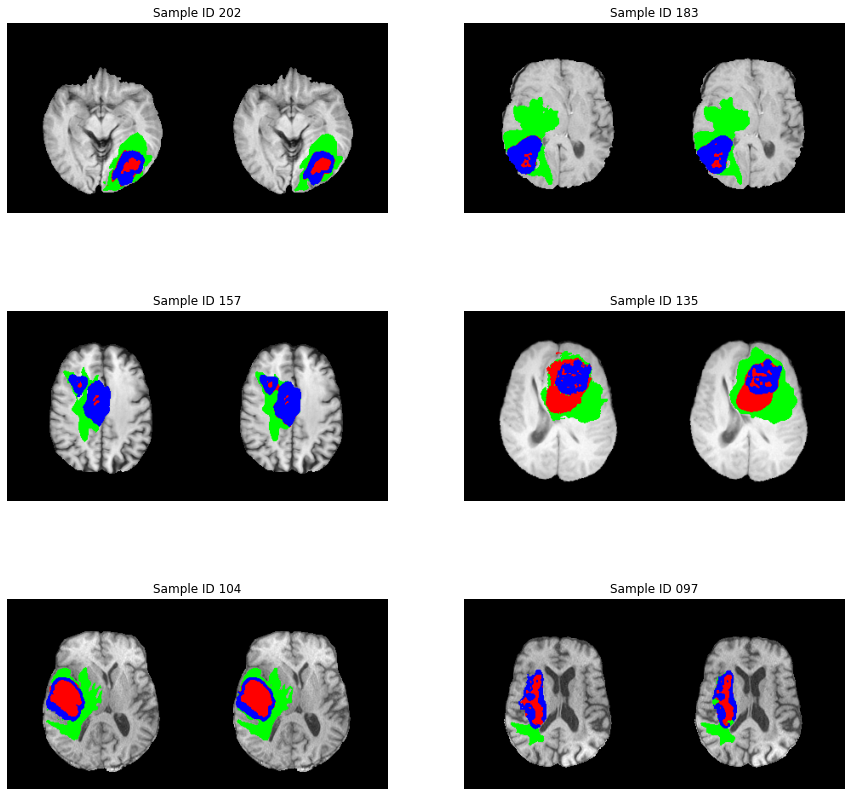

In [9]:
from skimage.io import imread, imsave
IDs = ["202-35", "183-55", "157-45", "135-39", "104-53", "097-53"]
imgs = [imread(f"{ID}.png") for ID in IDs]
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
ax = ax.flatten()
for i, img in enumerate(imgs):
    ax[i].imshow(img)
    ax[i].set_title(f"Sample ID {IDs[i][:-3]}")
    ax[i].axis('off')
plt.tight_layout
plt.show()